In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
test_sentence = "Artificial Intelligence can replace humans in several jobs and applications".split()
vocab = set(test_sentence)
vocab

{'Artificial',
 'Intelligence',
 'and',
 'applications',
 'can',
 'humans',
 'in',
 'jobs',
 'replace',
 'several'}

In [3]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
word_to_ix

{'can': 0,
 'several': 1,
 'applications': 2,
 'jobs': 3,
 'humans': 4,
 'Intelligence': 5,
 'and': 6,
 'in': 7,
 'Artificial': 8,
 'replace': 9}

In [4]:
n_grams = [([test_sentence[i-2], test_sentence[i - 1], test_sentence[i + 1], test_sentence[i + 2]], test_sentence[i])
  for i in range(2, len(test_sentence) - 2)]

In [5]:
for item in n_grams:
    print(item)

(['Artificial', 'Intelligence', 'replace', 'humans'], 'can')
(['Intelligence', 'can', 'humans', 'in'], 'replace')
(['can', 'replace', 'in', 'several'], 'humans')
(['replace', 'humans', 'several', 'jobs'], 'in')
(['humans', 'in', 'jobs', 'and'], 'several')
(['in', 'several', 'and', 'applications'], 'jobs')


In [6]:
class NGramLanguageModeler(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size):
    super(NGramLanguageModeler, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(context_size * embedding_dim, 128)
    self.linear2 = nn.Linear(128, vocab_size)

  def forward(self, inputs):
    embeds = self.embeddings(inputs).view((1, -1))
    out = F.relu(self.linear1(embeds))
    out = self.linear2(out)
    log_probs = F.log_softmax(out, dim=1)
    return log_probs

In [81]:
CONTEXT_SIZE = 4
EMBEDDING_DIM = 3

In [52]:
losses = []
acc=[]
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [53]:
for epoch in range(1000):
  total_loss = 0
  num_correct = 0
  num_examples = 0
  for context, target in n_grams:

      context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
      model.zero_grad()
      log_probs = model(context_idxs)
      loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
      loss.backward()
      optimizer.step()
      
      topv, topi = log_probs.topk(1)
      prediction = topi.item()

      if prediction == word_to_ix.get(target):
          num_correct += 1
      num_examples += 1

      total_loss += loss.item()
      
  train_loss = total_loss / len(n_grams)
  train_acc = (num_correct / num_examples)*100
  losses.append(train_loss)
  acc.append(train_acc)

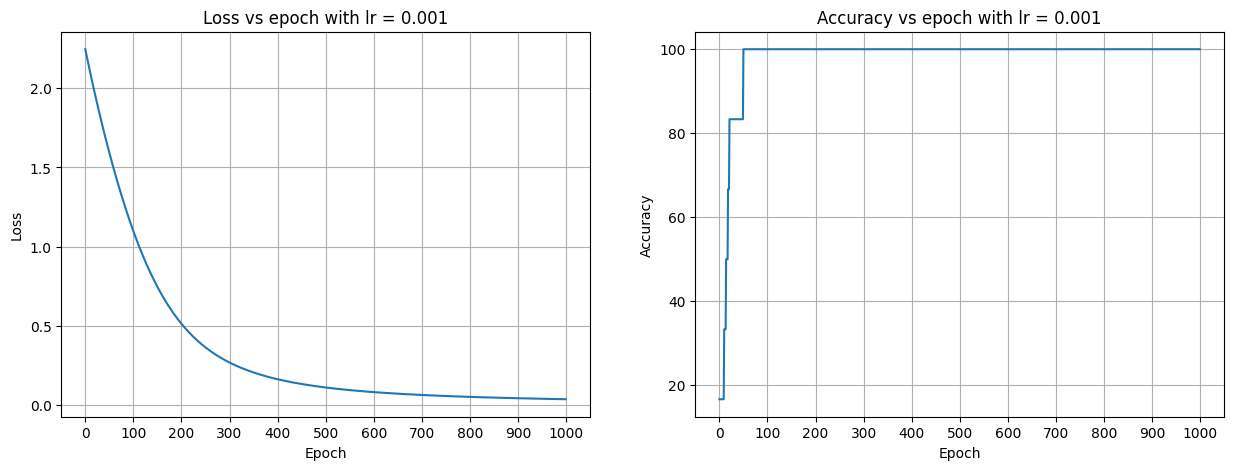

In [77]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (15, 5)

plt.subplot(1, 2, 1)
plt.title("Loss vs epoch with lr = 0.001")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 1001, 100))
plt.plot(losses)
plt.grid()

plt.subplot(1, 2, 2)
plt.title("Accuracy vs epoch with lr = 0.001")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 1001, 100))
plt.plot(acc)
plt.grid()

plt.show()

In [82]:
with torch.no_grad():
    total_loss = 0
    num_correct = 0
    num_examples = 0
    for context, target in n_grams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        log_probs = model(context_idxs)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        total_loss += loss.item()
        
        topv, topi = log_probs.topk(1)
        prediction = topi.item()

        if prediction == word_to_ix.get(target):
            num_correct += 1
        num_examples += 1
        
    test_loss = total_loss / len(n_grams)
    test_acc = (num_correct / num_examples)*100
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0351 | Test Accuracy: 100.0000


In [80]:
with torch.no_grad():
    context = ['can', 'replace', 'in', 'several']
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    log_probs = model(context_idxs)
    predicted_word = [k for k, v in word_to_ix.items() if v == torch.argmax(log_probs).item()] 

    print("Context:", context)
    print("Predicted word:", predicted_word)

Context: ['can', 'replace', 'in', 'several']
Predicted word: ['humans']
